Device: cpu


100.0%
100.0%
100.0%
100.0%
c:\ProgramData\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch x: torch.Size([128, 1, 28, 28]) Batch y: torch.Size([128]) Labels sample: [1, 2, 8, 5, 2, 6, 9, 9]


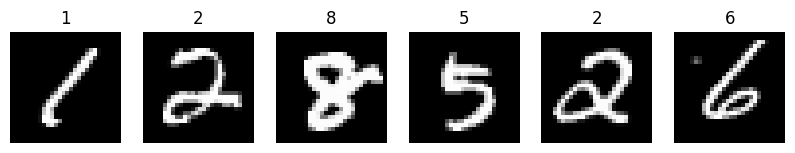

In [1]:
# ----- Block 1: Imports + Dataset -----

import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Get always the same results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# MNIST: pixels between 0 and 1
transform = transforms.ToTensor()

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Quick sanity check: visualize a few samples
x, y = next(iter(train_loader))
print("Batch x:", x.shape, "Batch y:", y.shape, "Labels sample:", y[:8].tolist())

fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x[i, 0].numpy(), cmap="gray")
    ax.set_title(str(y[i].item()))
    ax.axis("off")
plt.show()



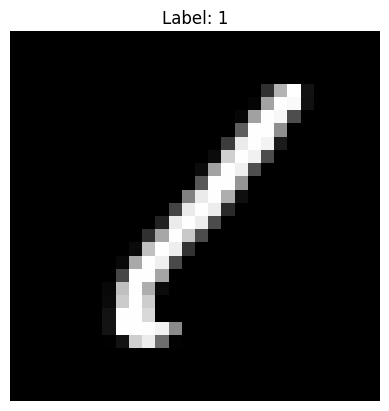

(1, 784)


In [ ]:
saved_input_idx = 1
saved_input_sample = x[saved_input_idx:saved_input_idx+1].to(device)
saved_input_label  = y[saved_input_idx:saved_input_idx+1].to(device)
plt.imshow(saved_input_sample[0, 0].cpu().numpy(), cmap="gray")
plt.title(f"Label: {saved_input_label.item()}")
plt.axis("off")
plt.show()

# Export input in a vector between 0 and 1 in a npz
print(saved_input_sample.cpu().view(saved_input_sample.size(0), -1).numpy().shape)
np.savez_compressed("mnist_sample_input.npz", input=saved_input_sample.cpu().view(saved_input_sample.size(0), -1).numpy(), label=saved_input_label.cpu().numpy()) 

In [3]:
# ----- Block 2: One neuron Is it a 0 ?  -----

# Create a new loader that map label (1 if 0 else 0)
def make_binary_loaders(batch_size=128):
    binary_target = lambda t: 1 if int(t) == 0 else 0

    train_bin = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform, target_transform=binary_target
    )
    test_bin = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform, target_transform=binary_target
    )

    train_bin_loader = DataLoader(train_bin, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_bin_loader  = DataLoader(test_bin,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_bin_loader, test_bin_loader

train_bin_loader, test_bin_loader = make_binary_loaders(BATCH_SIZE)

class SingleNeuronBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 1)  # 784 -> 1

    def forward(self, x):
        x = x.view(x.size(0), -1)      # flatten
        out = self.fc(x)            
        return out

model_bin = SingleNeuronBinary().to(device)
criterion = nn.BCEWithLogitsLoss()     # sigmoid included internally
optimizer = torch.optim.SGD(model_bin.parameters(), lr=0.1)

def eval_binary(model, loader):
    model.eval()
    correct, total = 0, 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)

            preds = (out >= 0).float()  # threshold at 0 logit
            correct += (preds == y).sum().item()
            total += x.size(0)
    return loss_sum / total, correct / total

EPOCHS = 1

# Training loop
test_loss, test_acc = eval_binary(model_bin, test_bin_loader)
print(f"Epoch 0 | test_loss={test_loss:.4f} | test_acc={test_acc*100:.2f}%")
for epoch in range(1, EPOCHS + 1):
    model_bin.train()
    for x, y in train_bin_loader:
        x = x.to(device)
        y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)

        optimizer.zero_grad()
        out = model_bin(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    test_loss, test_acc = eval_binary(model_bin, test_bin_loader)
    print(f"Epoch {epoch:02d} | test_loss={test_loss:.4f} | test_acc={test_acc*100:.2f}%")

# Export weights for later VHDL conversion (float)
W_bin = model_bin.fc.weight.detach().cpu().numpy()  # shape (1,784)
b_bin = model_bin.fc.bias.detach().cpu().numpy()    # shape (1,)


/tmp/ipykernel_7628/3182847473.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)


Epoch 0 | test_loss=0.6788 | test_acc=62.26%


/tmp/ipykernel_7628/3182847473.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)


Epoch 01 | test_loss=0.0415 | test_acc=98.97%


In [ ]:
# ===== Block 3: One layer (10-way) classification =====

class OneLayerMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)  # 784 -> 10

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

model_1 = OneLayerMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

def eval_multiclass(model, loader):
    model.eval()
    correct, total = 0, 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)

            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return loss_sum / total, correct / total

EPOCHS = 1

test_loss, test_acc = eval_multiclass(model_1, test_loader)
print(f"Epoch 0 | test_loss={test_loss:.4f} | test_acc={test_acc*100:.2f}%")

for epoch in range(1, EPOCHS + 1):
    model_1.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model_1(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    test_loss, test_acc = eval_multiclass(model_1, test_loader)
    print(f"Epoch {epoch:02d} | test_loss={test_loss:.4f} | test_acc={test_acc*100:.2f}%")

# Export weights (float)
W1 = model_1.fc.weight.detach().cpu().numpy()  # (10,784)
b1 = model_1.fc.bias.detach().cpu().numpy()    # (10,)
np.savez("mnist_lone_layer_weights.npz", W=W1, b_bin=b1)


# FIN ==================================================

Epoch 0 | test_loss=2.3419 | test_acc=9.04%
Epoch 01 | test_loss=0.3812 | test_acc=90.03%


In [ ]:
# SET THE BIAS TO 0 AND GET THE VALUE NEURON BY NEURON
# BONUS : TEST THE OUTPUT VALUES FOR A FIXED INPUT

test_input_value = (torch.ones((28*28))*0.0625).to(device)
int8_convert_ratio = (2**(8-1))-1
result_convert_ratio = (2**(15-1))-1
print(f"input value in hexa : {test_input_value[0]:.2f} -> {int(test_input_value[0]*int8_convert_ratio)} -> {hex(int(test_input_value[0]*int8_convert_ratio))}")

model_1.fc.bias = torch.nn.Parameter(torch.tensor(torch.zeros(10).to(device), dtype=torch.float32))
out_test = model_1(test_input_value.view(1,1,28,28))
# convert to integer between -128 and 127 for VHDL simulation where -128 is -1 and 127 is almost 1
converted_out_test= out_test.clamp(-1, 0.9921875)  # clamp to avoid overflow
out_test_int = (converted_out_test * result_convert_ratio).to(torch.int16)
print("\n expected output values (float -> int8 -> hexa) :")
for i in range(10) : 
    val_float = float(out_test[0][i])
    val_int = int(out_test_int[0][i])
    if out_test_int[0][i] < 0 :
        print(f"{val_float:2f} -> {val_int} -> {hex((2**16 + val_int))}")
    else :
        print(f"{val_float:2f} -> {val_int} -> {hex((val_int))}")


print("\nresults for saved input", model_1(saved_input_sample))
for i in range(10) : 
    val_float = float(model_1(saved_input_sample)[0][i])
    val_int = int((model_1(saved_input_sample)[0][i] * result_convert_ratio).clamp(-result_convert_ratio, result_convert_ratio-1))
    if val_int < 0 :
        print(f"{val_float:2f} -> {val_int} -> {hex((2**16 + val_int))}")
    else :
        print(f"{val_float:2f} -> {val_int} -> {hex((val_int))}")

input value in hexa : 0.06 -> 7 -> 0x7

 expected output values (float -> int8 -> hexa) :
0.177677 -> 2910 -> 0xb5e
-0.706889 -> -11580 -> 0xd2c4
0.347964 -> 5700 -> 0x1644
0.260581 -> 4269 -> 0x10ad
-0.200229 -> -3280 -> 0xf330
0.312143 -> 5113 -> 0x13f9
-0.017214 -> -282 -> 0xfee6
-0.068261 -> -1118 -> 0xfba2
0.183052 -> 2998 -> 0xbb6
-0.215809 -> -3535 -> 0xf231

 results for saved input tensor([[-0.3827,  3.2244,  1.2534,  1.3987, -1.5689,  0.3251, -1.8647, -2.9003,
          2.6056, -1.5241]], device='cuda:0', grad_fn=<AddmmBackward0>)
-0.382704 -> -6269 -> 0xe783
3.224383 -> 16382 -> 0x3ffe
1.253367 -> 16382 -> 0x3ffe
1.398744 -> 16382 -> 0x3ffe
-1.568905 -> -16383 -> 0xc001
0.325065 -> 5325 -> 0x14cd
-1.864678 -> -16383 -> 0xc001
-2.900279 -> -16383 -> 0xc001
2.605643 -> 16382 -> 0x3ffe
-1.524106 -> -16383 -> 0xc001


/tmp/ipykernel_7628/2529267476.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_1.fc.bias = torch.nn.Parameter(torch.tensor(torch.zeros(10).to(device), dtype=torch.float32))


In [ ]:
# SIMULATE THE VHDL NEURONS
# BONUS 2 : TEST VHDL WEIGHTS CONVERSION 

from quantization_functions import int_to_vhdl_hex
w0 = [0x00, 0xFD, 0x04, 0x00, 0x01, 0xFC, 0x02, 0xFF, 0xFD, 0x00, 0x02, 0x03, 0xFE, 0xFE, 0x00, 0x01, 0x01, 0x02, 0xFF, 0x02, 0x03, 0xFF, 0x03, 0x02, 0x04, 0xFE, 0xFE, 0xFF, 0x00, 0x02, 0xFE, 0x02, 0xFF, 0x02, 0x00, 0xFD, 0xFE, 0xFD, 0x02, 0xFD, 0x00, 0x00, 0xFE, 0x01, 0xFC, 0xFD, 0xFC, 0xFF, 0xFF, 0x00, 0x00, 0x02, 0x04, 0x01, 0xFF, 0xFC, 0x01, 0xFE, 0x02, 0x03, 0x01, 0x04, 0x04, 0x00, 0xFD, 0x03, 0xFE, 0xFE, 0x03, 0x02, 0x00, 0xFF, 0xFB, 0xFF, 0x03, 0x00, 0x00, 0xFF, 0xFF, 0x02, 0x00, 0x02, 0x00, 0x01, 0x01, 0x00, 0x02, 0x02, 0x04, 0x03, 0xFF, 0xFC, 0x00, 0xFF, 0xFE, 0xFE, 0xFF, 0x00, 0xFF, 0xFB, 0xFB, 0xFB, 0xFA, 0x00, 0x00, 0x01, 0xFF, 0x00, 0x01, 0xFC, 0x00, 0x00, 0xFE, 0xFD, 0x04, 0x03, 0x02, 0x03, 0xFE, 0xFE, 0x00, 0xFD, 0xFC, 0xFA, 0xFF, 0xFE, 0x01, 0x06, 0x00, 0xFF, 0x01, 0xFD, 0xFE, 0x01, 0xFD, 0xFC, 0xFD, 0xFF, 0xFE, 0xFE, 0x01, 0x00, 0xFF, 0xFD, 0xFF, 0xFE, 0xFD, 0xFA, 0xFD, 0xF8, 0xF9, 0xFB, 0x02, 0x02, 0x06, 0x0D, 0x0C, 0x0B, 0x01, 0x00, 0xFF, 0x02, 0xFF, 0xFA, 0xFF, 0xFC, 0xFF, 0xFF, 0x03, 0x01, 0x00, 0x00, 0xFF, 0x00, 0x00, 0xFE, 0xF9, 0xFF, 0xFD, 0xFF, 0x05, 0x09, 0x0C, 0x0C, 0x0B, 0x11, 0x10, 0x04, 0x04, 0x00, 0x00, 0xFF, 0xFC, 0xFE, 0x01, 0x00, 0xFD, 0x03, 0xFE, 0x00, 0x00, 0xFE, 0xF9, 0xFE, 0xF9, 0xFB, 0x00, 0xFF, 0x01, 0x03, 0x05, 0x08, 0x0C, 0x12, 0x0D, 0x09, 0x06, 0x04, 0x05, 0xFC, 0xFE, 0x00, 0x01, 0xFC, 0xFF, 0xFD, 0xFD, 0x01, 0xFE, 0x00, 0xFA, 0xFD, 0xFA, 0x00, 0xFE, 0x00, 0x00, 0x05, 0x0B, 0x0A, 0x09, 0x0E, 0x0F, 0x09, 0x0B, 0x05, 0x06, 0x00, 0xFC, 0xFE, 0x00, 0x00, 0xFE, 0x04, 0x00, 0xFD, 0xFC, 0x01, 0xFD, 0xFD, 0xFC, 0xFE, 0xFD, 0x00, 0x08, 0x0A, 0x09, 0x00, 0x07, 0x05, 0x0F, 0x10, 0x0D, 0x0B, 0x0C, 0x07, 0x02, 0xFD, 0x01, 0xFF, 0x00, 0xFD, 0xFF, 0xFD, 0xFD, 0xFB, 0xFB, 0x00, 0x01, 0x04, 0x04, 0x03, 0x02, 0x05, 0x01, 0xF7, 0xFB, 0x02, 0x07, 0x08, 0x10, 0x0E, 0x12, 0x09, 0x05, 0xFC, 0x04, 0xFF, 0x02, 0x00, 0x00, 0xFF, 0x00, 0xFD, 0xFD, 0x00, 0x04, 0x00, 0x05, 0x05, 0x07, 0x00, 0xF6, 0xEC, 0xE9, 0xF3, 0xFB, 0x0A, 0x08, 0x12, 0x18, 0x12, 0x07, 0xFC, 0x04, 0x00, 0xFC, 0x04, 0xFE, 0xFF, 0x01, 0xFE, 0x01, 0x05, 0x02, 0x05, 0x04, 0x07, 0xFE, 0xF2, 0xE5, 0xE6, 0xE3, 0xE6, 0xF9, 0x02, 0x0A, 0x0E, 0x16, 0x16, 0x0A, 0xFD, 0x04, 0x00, 0x02, 0x03, 0x03, 0xFC, 0x02, 0x00, 0x08, 0x05, 0x06, 0x09, 0x0A, 0x02, 0xF8, 0xEE, 0xE4, 0xDF, 0xDF, 0xE8, 0xF1, 0xFE, 0x07, 0x0C, 0x11, 0x12, 0x06, 0x00, 0xFF, 0x00, 0x02, 0xFF, 0x03, 0x02, 0xFC, 0x02, 0x07, 0x0A, 0x0A, 0x0D, 0x09, 0xFD, 0xEE, 0xE1, 0xE1, 0xD9, 0xD9, 0xE8, 0xF3, 0x01, 0x08, 0x11, 0x0E, 0x13, 0x0B, 0xFF, 0x04, 0x03, 0x00, 0x02, 0xFF, 0xFC, 0x00, 0x0A, 0x0B, 0x11, 0x0C, 0x14, 0x0D, 0xFB, 0xE7, 0xE1, 0xDB, 0xDB, 0xE1, 0xEF, 0xF7, 0x00, 0x07, 0x0B, 0x12, 0x0B, 0x06, 0x00, 0xFF, 0x03, 0x00, 0xFC, 0x00, 0xFD, 0x00, 0x09, 0x0B, 0x10, 0x12, 0x0F, 0x0B, 0xF6, 0xEB, 0xE0, 0xD8, 0xE0, 0xEB, 0xF1, 0xFC, 0x08, 0x0A, 0x06, 0x0D, 0x09, 0x00, 0x00, 0x01, 0xFF, 0x01, 0xFD, 0x03, 0x02, 0x02, 0x0A, 0x11, 0x0E, 0x11, 0x10, 0x04, 0xF4, 0xEE, 0xE6, 0xDD, 0xE8, 0xF3, 0x00, 0x05, 0x09, 0x03, 0x09, 0x0C, 0x01, 0xFF, 0x00, 0x02, 0xFE, 0x00, 0x00, 0x00, 0xFC, 0x02, 0x0B, 0x0A, 0x10, 0x12, 0x12, 0x0D, 0xFD, 0xF0, 0xEF, 0xEA, 0xF1, 0xFB, 0xFE, 0x04, 0x00, 0x03, 0x04, 0x05, 0x00, 0xFD, 0x01, 0x03, 0xFC, 0x01, 0xFD, 0x00, 0x02, 0x02, 0x02, 0x0D, 0x10, 0x10, 0x15, 0x0A, 0x01, 0xF9, 0xF7, 0xF9, 0xFD, 0xFF, 0x01, 0x04, 0xFE, 0x00, 0x02, 0x00, 0x01, 0x00, 0x02, 0x00, 0xFE, 0x03, 0x00, 0xFF, 0xFC, 0x00, 0x00, 0x08, 0x0B, 0x09, 0x0E, 0x0C, 0x0D, 0x06, 0x00, 0x03, 0x01, 0x00, 0x04, 0x01, 0x03, 0x00, 0x04, 0x02, 0x01, 0xFB, 0x03, 0xFD, 0x04, 0x00, 0xFC, 0x01, 0xFE, 0xFC, 0x00, 0x05, 0x0A, 0x08, 0x11, 0x11, 0x0F, 0x0A, 0x03, 0x02, 0x04, 0x00, 0xFF, 0xFF, 0xFB, 0xFD, 0xFE, 0xFE, 0xFD, 0x00, 0x00, 0x01, 0x00, 0xFE, 0xFF, 0x00, 0xFD, 0xFF, 0x00, 0x05, 0x06, 0x0C, 0x0C, 0x0D, 0x14, 0x0E, 0x0F, 0x0A, 0x06, 0x01, 0x03, 0xFF, 0xFE, 0x00, 0xF9, 0xFF, 0x02, 0x02, 0xFD, 0x01, 0xFE, 0x00, 0x00, 0xFD, 0xFC, 0xFD, 0x01, 0x02, 0xFF, 0x02, 0x07, 0x07, 0x10, 0x12, 0x0D, 0x04, 0x04, 0x00, 0x00, 0xF9, 0xF7, 0xFE, 0xFE, 0xFE, 0xFE, 0xFE, 0x03, 0x00, 0x03, 0x04, 0x00, 0x00, 0x00, 0x02, 0xFC, 0x00, 0xFE, 0x00, 0xFE, 0xFC, 0xFD, 0x00, 0xFC, 0xFB, 0xFB, 0xF9, 0xFD, 0xFF, 0xFC, 0x01, 0xFD, 0xFD, 0xFE, 0xFD, 0xFD, 0xFC, 0xFC, 0x01, 0x02, 0x04, 0x03, 0x00, 0x00, 0xFD, 0x00, 0xFA, 0xFF, 0xFC, 0xFD, 0xFD, 0xF9, 0xFF, 0xFE, 0xFF, 0xFD, 0x00, 0x01, 0x00, 0x02, 0xFF, 0x02, 0x01, 0x02, 0x04, 0x01, 0xFF, 0x00, 0x01, 0x00, 0xFF, 0x03, 0x02, 0xFD, 0xFF, 0xFF, 0xFC, 0xFF, 0xFD, 0xFC, 0xFD, 0xFD, 0x02, 0x00, 0x03, 0x00, 0x00, 0x01, 0x00, 0xFD, 0xFE, 0xFF, 0x00, 0x01, 0x01, 0x03, 0x00, 0xFF, 0xFD, 0xFD, 0xFE, 0x01, 0x02, 0x03, 0xFF, 0x00, 0xFF, 0x00, 0x01, 0x00, 0x00, 0x00, 0x01, 0xFF, 0xFE, 0x01, 0x00, 0xFE, 0x01, 0x00, 0x00, 0xFE]
w1 = [0x00, 0xFD, 0x01, 0x00, 0x02, 0x00, 0x00, 0x01, 0x03, 0xFE, 0x02, 0x01, 0xFD, 0x01, 0xFE, 0xFF, 0xFE, 0xFD, 0x03, 0xFC, 0x02, 0xFC, 0x00, 0x00, 0x03, 0xFF, 0x01, 0x00, 0x02, 0x00, 0x01, 0xFE, 0xFD, 0x04, 0xFD, 0x00, 0x00, 0x04, 0xFF, 0xFD, 0xFF, 0x02, 0x01, 0x03, 0x00, 0x02, 0xFC, 0x01, 0x02, 0x02, 0xFE, 0xFF, 0x01, 0xFD, 0xFD, 0xFC, 0x00, 0x02, 0x01, 0x00, 0x01, 0xFE, 0x00, 0xFF, 0xFE, 0x03, 0xFD, 0x00, 0xFC, 0x00, 0xFE, 0x01, 0xFE, 0x02, 0xFC, 0x02, 0xFD, 0x02, 0xFE, 0x00, 0x00, 0x02, 0x01, 0xFD, 0x00, 0xFD, 0x03, 0x00, 0xFF, 0xFE, 0x01, 0xFE, 0x01, 0x01, 0x00, 0xFF, 0xFA, 0x01, 0xFD, 0xFE, 0xFE, 0x00, 0x00, 0xFF, 0x00, 0xFB, 0x00, 0xFC, 0x01, 0xFD, 0xFF, 0x03, 0x04, 0xFE, 0xFE, 0x00, 0x01, 0x00, 0xFF, 0xFC, 0x00, 0x01, 0xFB, 0x00, 0x03, 0x08, 0x04, 0x03, 0x04, 0x02, 0x05, 0x03, 0x08, 0x08, 0x00, 0x01, 0xFF, 0x02, 0xFE, 0x00, 0x02, 0xFC, 0xFD, 0xFE, 0x02, 0x02, 0xFC, 0xFF, 0xF9, 0xF8, 0xFE, 0xFF, 0x00, 0x07, 0x07, 0x04, 0xFE, 0xFC, 0x04, 0x07, 0x0C, 0x07, 0x07, 0x04, 0x02, 0x00, 0x04, 0x00, 0x00, 0x04, 0x04, 0xFF, 0x03, 0x00, 0xFE, 0x00, 0xF6, 0xF8, 0xF9, 0xF4, 0xFA, 0xFD, 0x00, 0xF7, 0xF5, 0xF9, 0x01, 0x07, 0x0A, 0x06, 0xFF, 0xFC, 0xFF, 0x03, 0x00, 0x00, 0xFD, 0xFE, 0xFD, 0x03, 0xFF, 0xFB, 0xFD, 0xFA, 0xF5, 0xF3, 0xF2, 0xED, 0xF3, 0xFC, 0xF9, 0xF5, 0xF9, 0xF7, 0xFB, 0x00, 0xFE, 0x01, 0xFB, 0xF9, 0xF9, 0x00, 0x00, 0x00, 0xFF, 0xFE, 0x00, 0x03, 0xFD, 0xFF, 0xF8, 0xF6, 0xF8, 0xF0, 0xF2, 0xED, 0xF2, 0xFB, 0x06, 0x00, 0x00, 0xFF, 0x00, 0xFF, 0xF8, 0xFA, 0xF4, 0xF7, 0xFE, 0xFF, 0x00, 0xFF, 0xFE, 0x02, 0x00, 0x00, 0x00, 0x01, 0xFA, 0xF8, 0xF8, 0xF4, 0xEC, 0xEA, 0xF6, 0x03, 0x0F, 0x15, 0x05, 0x02, 0xF9, 0xFA, 0xF7, 0xF5, 0xFA, 0xF6, 0xF8, 0xFA, 0x02, 0x01, 0xFD, 0x02, 0x04, 0xFC, 0x02, 0xFF, 0xFD, 0xFE, 0xFB, 0xF4, 0xF3, 0xF0, 0xF5, 0x02, 0x1D, 0x1D, 0x10, 0x00, 0xF8, 0xF1, 0xF0, 0xF9, 0xFB, 0xFE, 0xFC, 0xFF, 0xFF, 0x03, 0xFF, 0x02, 0x03, 0xFC, 0x00, 0xFE, 0xFB, 0xFD, 0xF7, 0xF6, 0xEB, 0xED, 0xEE, 0x08, 0x29, 0x2D, 0x10, 0xF8, 0xF6, 0xF0, 0xF6, 0xF5, 0xFB, 0x00, 0xFB, 0xFC, 0x00, 0x00, 0x00, 0x03, 0xFE, 0xFE, 0xFD, 0xFE, 0xFC, 0xFE, 0xF7, 0xF3, 0xE9, 0xEB, 0xF2, 0x0B, 0x32, 0x26, 0x09, 0xF2, 0xF0, 0xF8, 0xF4, 0xFF, 0xFE, 0x01, 0xFD, 0x02, 0x00, 0x00, 0x03, 0xFC, 0xFD, 0x04, 0xFE, 0xFC, 0xFD, 0xF9, 0xF7, 0xEE, 0xEA, 0xE0, 0xEE, 0x1A, 0x36, 0x24, 0xFF, 0xED, 0xEE, 0xF2, 0xF6, 0xF9, 0x01, 0xFE, 0x00, 0x02, 0x00, 0xFE, 0xFD, 0xFF, 0x01, 0xFD, 0x00, 0x00, 0x00, 0xFC, 0xF7, 0xF3, 0xEA, 0xE5, 0xF2, 0x1C, 0x30, 0x1A, 0xF4, 0xE8, 0xEF, 0xF7, 0xF6, 0xF7, 0xFB, 0xFC, 0x01, 0xFD, 0x00, 0x00, 0xFE, 0x02, 0xFF, 0x00, 0xFD, 0xFE, 0xFD, 0xFA, 0xF4, 0xF1, 0xE8, 0xEA, 0xFD, 0x23, 0x29, 0x13, 0xEA, 0xE4, 0xED, 0xF4, 0xF7, 0xFD, 0xFA, 0xFF, 0xFF, 0xFC, 0xFF, 0x01, 0x00, 0x03, 0x03, 0xFE, 0xFE, 0xFD, 0xF8, 0xF7, 0xF1, 0xF3, 0xF3, 0xF8, 0x05, 0x21, 0x25, 0x05, 0xEA, 0xE7, 0xF1, 0xF4, 0xF8, 0xF9, 0xFE, 0xFF, 0xFB, 0xFD, 0x00, 0x01, 0x02, 0xFE, 0xFC, 0x00, 0xFF, 0xFE, 0xF8, 0xFA, 0xF5, 0xF7, 0xF6, 0x02, 0x10, 0x20, 0x1E, 0xFB, 0xF0, 0xE9, 0xEE, 0xF5, 0xF7, 0xFC, 0xFF, 0xFA, 0x00, 0xFF, 0xFF, 0x00, 0x03, 0xFE, 0xFD, 0x02, 0xFD, 0xFD, 0xF6, 0xF6, 0xF9, 0xF7, 0xFD, 0x09, 0x11, 0x18, 0x0D, 0x01, 0xF0, 0xEC, 0xEE, 0xF3, 0xFA, 0xFA, 0xFF, 0xFD, 0xFE, 0x01, 0x00, 0x00, 0x01, 0x03, 0x01, 0x02, 0x01, 0xFC, 0xF8, 0xF7, 0xF8, 0x00, 0x06, 0x09, 0x0A, 0x11, 0x05, 0x01, 0xF7, 0xF4, 0xF3, 0xF3, 0xFC, 0xF9, 0xFD, 0x00, 0xFB, 0x00, 0xFF, 0x03, 0xFE, 0x02, 0x02, 0x01, 0x02, 0xFD, 0xF6, 0xFD, 0xFD, 0x01, 0x00, 0x02, 0x00, 0x06, 0x05, 0x01, 0xFD, 0xF4, 0xF5, 0xF6, 0xF8, 0xFF, 0xFE, 0x01, 0xFF, 0xFC, 0xFF, 0x03, 0x02, 0x01, 0xFF, 0xFC, 0xFD, 0x01, 0xFE, 0x02, 0x03, 0x01, 0x04, 0xFB, 0xF8, 0xF8, 0xFB, 0x01, 0x00, 0xFA, 0xFD, 0xF6, 0xF7, 0xFA, 0xFC, 0xFE, 0xFF, 0x01, 0xFC, 0x00, 0x00, 0x01, 0x04, 0x02, 0xFE, 0xFF, 0x03, 0x03, 0x08, 0x04, 0x02, 0xF8, 0xF1, 0xF7, 0x00, 0x04, 0x08, 0xFE, 0x00, 0xFA, 0xF9, 0xFD, 0x00, 0x02, 0x00, 0x00, 0x00, 0xFF, 0x00, 0x00, 0x03, 0x02, 0xFD, 0x02, 0x02, 0x06, 0x03, 0x05, 0xFA, 0xFB, 0xF9, 0xF6, 0xFD, 0x06, 0x05, 0x04, 0xFC, 0x00, 0xFB, 0xFD, 0xFD, 0x01, 0x00, 0xFC, 0xFE, 0xFE, 0xFC, 0x00, 0x01, 0x00, 0xFF, 0x00, 0xFE, 0xFE, 0xFE, 0x00, 0xF6, 0xF7, 0xF3, 0xF5, 0xF5, 0x00, 0x01, 0xFF, 0x01, 0x02, 0x01, 0x01, 0xFC, 0xFC, 0xFD, 0x01, 0xFD, 0xFD, 0xFE, 0xFC, 0x00, 0x00, 0xFE, 0x02, 0xFE, 0xFD, 0x00, 0x00, 0xFA, 0xF7, 0xF8, 0xFB, 0xFE, 0xFE, 0xFC, 0xFB, 0xFC, 0xFF, 0x00, 0xFE, 0xFD, 0x00, 0xFD, 0xFD, 0xFD, 0xFF, 0x04, 0x01, 0x00, 0x00, 0x01, 0x00, 0xFD, 0xFD, 0xFD, 0x00, 0xFB, 0xFE, 0xFD, 0x02, 0x02, 0x01, 0x00, 0xFF, 0x00, 0xFD, 0xFE, 0x00, 0xFF, 0xFC, 0x01, 0x03, 0xFE, 0x01, 0x00, 0x00, 0x00, 0x03, 0x00, 0xFE, 0xFF, 0x02, 0x01, 0x00, 0x00, 0xFF, 0xFF, 0xFE, 0x00, 0x01, 0x03, 0xFF, 0x00, 0x02, 0x01, 0x00, 0x01, 0x00, 0xFD, 0x00, 0x00, 0x04]

neuron_idx = 1
if neuron_idx == 0 : 
    w_hex = w0
else :
    w_hex = w1


saved_input_coe = [0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x18, 0x59, 0x7F, 0x09, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x02, 0x51, 0x7E, 0x7C, 0x08, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03, 0x50, 0x7E, 0x7B, 0x26, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x2F, 0x7E, 0x7E, 0x47, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x1E, 0x75, 0x7E, 0x79, 0x0D, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x05, 0x67, 0x7E, 0x78, 0x26, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x05, 0x50, 0x7E, 0x77, 0x27, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x2B, 0x7E, 0x7E, 0x4A, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x40, 0x75, 0x7E, 0x56, 0x07, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x22, 0x75, 0x7E, 0x76, 0x15, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x11, 0x75, 0x7E, 0x76, 0x25, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x18, 0x53, 0x7E, 0x64, 0x25, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x05, 0x5F, 0x7E, 0x76, 0x19, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x54, 0x7E, 0x77, 0x25, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x23, 0x7E, 0x7E, 0x52, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x5F, 0x7E, 0x56, 0x05, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x05, 0x65, 0x7E, 0x66, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0x7E, 0x7E, 0x6C, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0x7E, 0x7E, 0x7E, 0x79, 0x44, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0x66, 0x75, 0x36, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]
saved_input_sample_flatten = saved_input_sample.view(-1).cpu().numpy().tolist()
print(int8_convert_ratio, result_convert_ratio)
w_int = (model_1.fc.weight.detach().cpu()[neuron_idx]*int8_convert_ratio).to(torch.int8)
w_float = model_1.fc.weight.detach().cpu()[neuron_idx]
res = 0
res_int = 0
res_float = 0.0
for i, w in enumerate(w_hex) : 
    if w > 127 :
        w = w - 256
    res = res + w*saved_input_coe[i]
    res_int = res_int + int(w_int[i])*saved_input_coe[i]
    res_float = res_float + float(w_float[i])*saved_input_sample_flatten[i]

hex_res = int_to_vhdl_hex(res,16)
hex_res_int = int_to_vhdl_hex(res_int,16)
hex_res_float = int_to_vhdl_hex(int(res_float*int8_convert_ratio),16)
print(f"hexa : {res}, {hex_res}, {res/result_convert_ratio:.4f}")
print(f"int  : {res_int}, {hex_res_int}, {res_int/result_convert_ratio:.4f}")
print(f"float: {res_float}, {(int(res_float*result_convert_ratio))}, {hex_res_float}")

NameError: name 'saved_input_sample' is not defined

In [7]:
# ===== Block 4: Two-layer MLP (128 -> 10) =====

class TwoLayerMNIST(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden)  # 784 -> 128
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 10)     # 128 -> 10

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act(x)
        out = self.fc2(x)
        return out

model_2 = TwoLayerMNIST(hidden=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)

EPOCHS = 1
test_loss, test_acc = eval_multiclass(model_2, test_loader)
print(f"Epoch 0 | test_loss={test_loss:.4f} | test_acc={test_acc*100:.2f}%")

for epoch in range(1, EPOCHS + 1):
    model_2.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model_2(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    test_loss, test_acc = eval_multiclass(model_2, test_loader)
    print(f"Epoch {epoch:02d} | test_loss={test_loss:.4f} | test_acc={test_acc*100:.2f}%")

# Export weights (float)
W2_1 = model_2.fc1.weight.detach().cpu().numpy()  # (128,784)
b2_1 = model_2.fc1.bias.detach().cpu().numpy()    # (128,)
W2_2 = model_2.fc2.weight.detach().cpu().numpy()  # (10,128)
b2_2 = model_2.fc2.bias.detach().cpu().numpy()    # (10,)

print("Two-layer shapes:",
      "\n  W2_1", W2_1.shape, "b2_1", b2_1.shape,
      "\n  W2_2", W2_2.shape, "b2_2", b2_2.shape)

np.savez("mnist_l1_weights.npz", W=W2_1, b_bin=b2_1)
np.savez("mnist_l2_weights.npz", W=W2_2, b_bin=b2_2)


Epoch 0 | test_loss=2.2990 | test_acc=12.96%
Epoch 01 | test_loss=0.2253 | test_acc=93.49%
Two-layer shapes: 
  W2_1 (128, 784) b2_1 (128,) 
  W2_2 (10, 128) b2_2 (10,)
